# Final Project - Image Processing

## Group Members (Name/USP ID):
- André Seiti Caniza 9790923
- Bruno Waldvogel 9857690
- Marcel Otoboni de Lima 9791069


**Note:** To get the most out of this project please upload all the contents of the folder "images" into this colab notebook. All the image files used as examples are located there.

## Section 1 - Pixelizer Function Definitions

**Description of steps used to pixelate an image:**


1.   First, we segment the image using k-means to extract the *n* most predominant colors in the image, and those extracted colors form our color palette that will be used in the pixel-art representation of the image.
2.   After that, the image is divided into blocks, each containing a group of pixels. So, it is important to note that **no downscaling is done** when transforming the image to pixel-art. The colors of the pixels of each block are then averaged and we check which color in the palette is the closest one that is related to the averaged color, and then we fill each pixel in the block with that color in the palette.
3.   If we want to apply a black contour that is typical of a pixel-art representation of an object, we convert the image to grayscale, threshold the image according to some value, and then find the contour of the object using edge detection. With the edges in place, we fill the pixel values that represent edges with the color black. *Observation*: This step is tricky to get right. We failed way too many times in this step because it is a try-and-error process that it is time-consuming and kinda impossible to do with images that blend well with the background, such as a white ghost in a white background. Thus, a clear distinction between foreground and background is needed if this step is to be considered.







In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from math import inf

In [0]:
class Pixelizer:
  
  def __init__(self):
    self.img = None
    self.palette = None
  
  def read_image(self, filename):
    """ This function reads an image given by a relative file path <filename>.
    
    Arguments:
      filename (string) - The relative path to the file.
    """
    # Reading the image and assigning the color to RGB
    img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    self.img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
  def threshold_img(self, img, threshold):
    """ This function thresholds an image <img> according to some value given by <threshold>.
    
    Arguments:
      img (np.array) - The image to be thresholded.
      threshold (int) - The threshold value.
      
    Returns:
      thresholded (np.array) - The thresholded image.
    """
    
    if(threshold > 255 or threshold < 0):
      print("Illegal threshold value! Please provide a value in range 0-255")
      return None
    
    # Transforming an image to grayscale to perform the thresholding
    gray_img = cv2.cvtColor(original, cv2.COLOR_RGB2GRAY)
    
    # Thresholding the image according to the value given
    thresholded = np.copy(gray_img)
    thresholded[gray_img > threshold] = 255
    thresholded[gray_img <= threshold] = 0

    return thresholded
  
  def extract_dominant_colors(self, n_colors):
    """ This function extracts the <n_colors> most dominant colors present in an image
    using the K-Means clustering algorithm, to later be used as a palette in the 
    pixelized version of the image.
    
    Arguments:
      n_colors(int) - The number of colors in the palette.
      
    Returns:
      The most dominant colors in an image.
    """
    # Extracting the width, height and depth of an image
    width, height, depth = self.img.shape
    copied_img = np.copy(self.img)

    # Getting a list of all the pixel values
    all_pixels = copied_img.reshape((width * height, depth))

    # Using the K-Means algorithm to extract the dominant colors
    k_means = KMeans(n_clusters=n_colors).fit(all_pixels)

    # Returning the dominant colors to the caller
    return k_means.cluster_centers_.astype(np.uint8)
  
  def assign_color_to_block(self, mean_values):
    """ This function checks to see which color must be assigned for each block
    of pixels in the pixelized image, using the minimum Euclidian Distance 
    between the colors as the deciding factor.
    
    Arguments:
      mean_values(list) - A list containing mean values for the R,G,B components of a block.
    
    Returns:
      The chosen color to be assigned to a block. Format-> list()
    """
    chosen_color = 0
    min_eucl_dist = inf
    
    # For each color in the palete
    for j in range(0,len(self.palette)):
      # Performing the euclidian distance and checking to see if it is the minimum that we want
      eucl_dist = np.sum(np.power(np.subtract(mean_values, self.palette[j]), 2))
      # Check to see if this color should be used or not
      if(eucl_dist < min_eucl_dist):
        min_eucl_dist = eucl_dist
        chosen_color = j
        
    # Returning the color to be assigned back to the caller
    return self.palette[chosen_color]
    
  def pixelize(self, filename, factor, threshold, n_colors, contour=False):
    """ This function applies the pixelization effect encountered in pixel-art
    to a given image, giving the relative path <filename> to the image, the number of
    blocks that it will be divided into, the threshold for the black iconified contour and
    the number of colors considered in the palette of colors.
    
    Arguments:
      filename(string) - The relative path to the image.
      factor(int) - The factor to divide the image into blocks.
      threshold(int) - 0-255 value corresponding to the minimum threshold for the contour separation.
      n_colors(int) - The number of colors to be considered in the palette of colors.
      contour(bool) - True of False indicating if the image will have the iconic black contour.
      
    Returns:
      The pixelized image.
    """
    # Reading the image
    self.read_image(filename)
    
    # Copying the image so that we dont lose the original one
    img = np.copy(self.img)
    
    # Extracting the dominant colors to be used in the pixel art palette
    self.palette = self.extract_dominant_colors(n_colors)[:, :3]
    
    # Applying a black contour to the image, typical of the pixel-art art style
    if(contour):
      thresh = self.threshold_img(img, threshold)
      _, contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
      cv2.drawContours(img, contours, -1, (0,0,0), int(np.ceil(img.shape[0] * img.shape[1] * 0.000005)))
    
    # Calculating the width and height of each block of pixels
    blockWidth = img.shape[0] // factor
    blockHeight = img.shape[1] // factor
    
    # Assigning colors to each block after calculating the mean RGB values for each block
    # and performing a lookup in a palette of pre-defined colors
    for i in range(0, img.shape[0], blockHeight):
      for j in range(0, img.shape[1], blockWidth):
        aux = img[i : i+blockHeight, j:j+blockWidth, :]
        mean_r = np.mean(aux[:,:,0])
        mean_g = np.mean(aux[:,:,1])
        mean_b = np.mean(aux[:,:,2])
        mean_values = [mean_r ,mean_g, mean_b]
        chosen_color = self.assign_color_to_block(mean_values)
        img[i : i+blockHeight, j : j+blockWidth] = chosen_color
    
    # Returning the pixelized image back to the caller
    return img
  
  def pixelize_with_image(self, img, factor, threshold, n_colors, contour=False):
    """ This function applies the pixelization effect encountered in pixel-art
    to a given image, giving the relative path <filename> to the image, the number of
    blocks that it will be divided into, the threshold for the black iconified contour and
    the number of colors considered in the palette of colors.
    
    Arguments:
      filename(string) - The relative path to the image.
      factor(int) - The factor to divide the image into blocks.
      threshold(int) - 0-255 value corresponding to the minimum threshold for the contour separation.
      n_colors(int) - The number of colors to be considered in the palette of colors.
      contour(bool) - True of False indicating if the image will have the iconic black contour.
      
    Returns:
      The pixelized image.
    """
    self.img = img
    
    if(not np.all(self.palette)):
      # Extracting the dominant colors to be used in the pixel art palette
      self.palette = self.extract_dominant_colors(n_colors)[:, :3]

    # Applying a black contour to the image, typical of the pixel-art art style
    if(contour):
      thresh = self.threshold_img(img, threshold)
      _, contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
      cv2.drawContours(img, contours, -1, (0,0,0), int(np.ceil(img.shape[0] * img.shape[1] * 0.000005)))
    
    # Calculating the width and height of each block of pixels
    blockWidth = img.shape[0] // factor
    blockHeight = img.shape[1] // factor
    
    # Assigning colors to each block after calculating the mean RGB values for each block
    # and performing a lookup in a palette of pre-defined colors
    for i in range(0, img.shape[0], blockHeight):
      for j in range(0, img.shape[1], blockWidth):
        aux = img[i : i+blockHeight, j:j+blockWidth, :]
        mean_r = np.mean(aux[:,:,0])
        mean_g = np.mean(aux[:,:,1])
        mean_b = np.mean(aux[:,:,2])
        mean_values = [mean_r ,mean_g, mean_b]
        chosen_color = self.assign_color_to_block(mean_values)
        img[i : i+blockHeight, j : j+blockWidth] = chosen_color
    
    # Returning the pixelized image back to the caller
    return img

## Section 2 - Pixelizer Results

**Note:** This section can be used as a demo program to run small instances of several images.

To get a right representation, we have to mix and match the parameters of the pixelize function. Here, we divide the original image in 50 blocks in the width and the height and fill the palette with 12 colors. It is clearly visible that a smooth transition in the original left image is replaced with a abrupt transition in the right image.

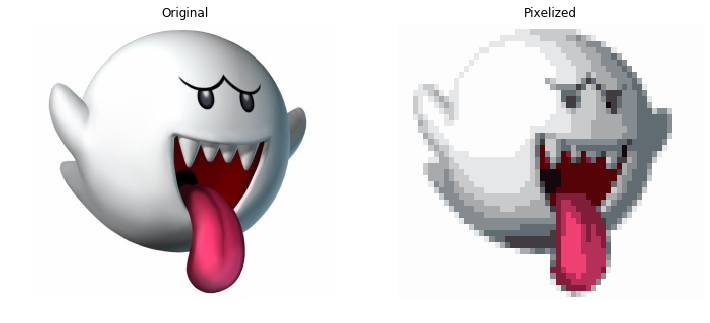

In [0]:
pix = Pixelizer()
boo1 = pix.pixelize('boo.jpg', 50, 200, 12, False)
fig = plt.figure(figsize=(12, 12))

fig.add_subplot(1, 2, 1)
plt.grid(False)
plt.title("Original")
plt.axis('off')
plt.imshow(pix.img)

fig.add_subplot(1, 2, 2)
plt.grid(False)
plt.title("Pixelized")
plt.axis('off')
plt.imshow(boo1)

The example below shows that the algorithm has a hard time filling eyes with the right color, which are always kind of gray instead of clear white.

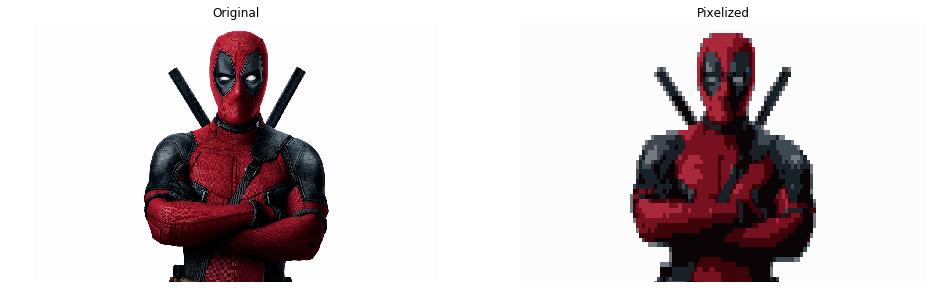

In [0]:
deadp1 = pix.pixelize('deadpool.jpg', 80, 200, 8, False)
fig = plt.figure(figsize=(16, 16))

fig.add_subplot(1, 2, 1)
plt.grid(False)
plt.title("Original")
plt.axis('off')
plt.imshow(pix.img)

fig.add_subplot(1, 2, 2)
plt.grid(False)
plt.title("Pixelized")
plt.axis('off')
plt.imshow(deadp1)

Below is an example of different number of blocks considered to form the pixel-art. 

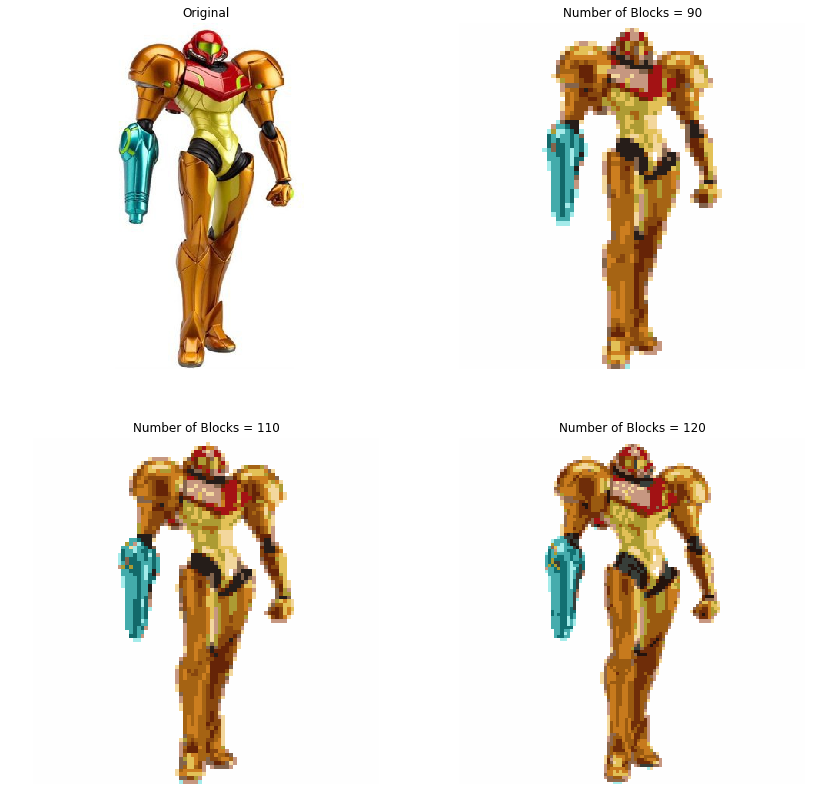

In [0]:
samus1 = pix.pixelize('samus.jpeg', 70, 200, 15, False)
samus2 = pix.pixelize('samus.jpeg', 90, 200, 15, False)
samus3 = pix.pixelize('samus.jpeg', 110, 200, 15, False)
fig = plt.figure(figsize=(14, 14))

fig.add_subplot(2, 2, 1)
plt.grid(False)
plt.title("Original")
plt.axis('off')
plt.imshow(pix.img)

fig.add_subplot(2, 2, 2)
plt.grid(False)
plt.title("Number of Blocks = 90")
plt.axis('off')
plt.imshow(samus1)

fig.add_subplot(2, 2, 3)
plt.title("Number of Blocks = 110")
plt.axis('off')
plt.grid(False)
plt.imshow(samus2)

fig.add_subplot(2, 2, 4)
plt.title("Number of Blocks = 120")
plt.axis('off')
plt.grid(False)
plt.imshow(samus3)

In the example below we can see a clear distinction in each pixel-art using different ammounts of colors in the color palette.

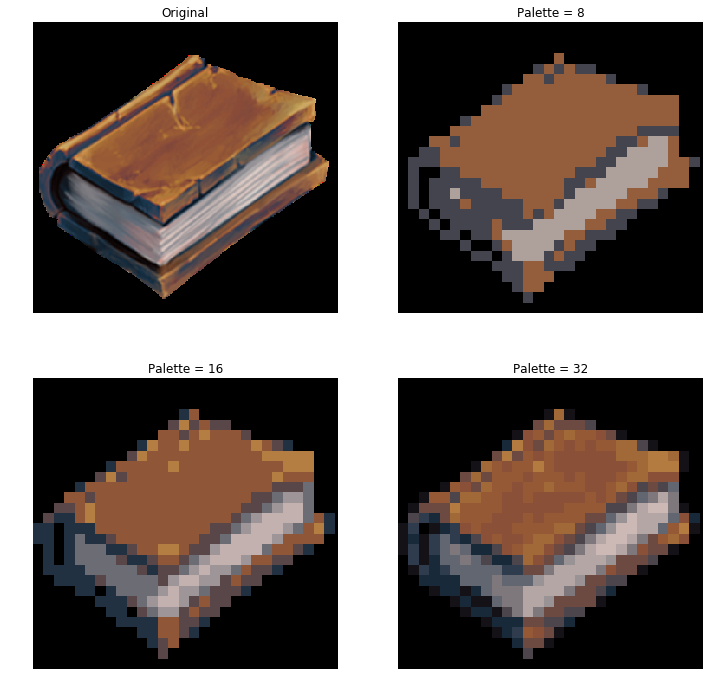

In [0]:
book1 = pix.pixelize('book.png', 28, 200, 4, False)
book2 = pix.pixelize('book.png', 28, 200, 8, False)
book3 = pix.pixelize('book.png', 28, 200, 16, False)
fig = plt.figure(figsize=(12, 12))

fig.add_subplot(2, 2, 1)
plt.grid(False)
plt.title("Original")
plt.axis('off')
plt.imshow(pix.img)

fig.add_subplot(2, 2, 2)
plt.grid(False)
plt.title("Palette = 8")
plt.axis('off')
plt.imshow(book1)

fig.add_subplot(2, 2, 3)
plt.title("Palette = 16")
plt.axis('off')
plt.grid(False)
plt.imshow(book2)

fig.add_subplot(2, 2, 4)
plt.title("Palette = 32")
plt.axis('off')
plt.grid(False)
plt.imshow(book3)

## Section 3 - Depixelizer Function Definitions

**How to depixelate an image :**

  To depixelate an image is to transform a small sized pixel-art image into a smooth contour-lined upscaled image. So, in this section we are looking for a good algorithm that can upscale a pixel-art image while also maintaining the transitions of the pixel-art, so that no blurring is done. Because blurring is undesirable, the bilinear and bicubic upscaling methods are out of  question.  In this case we used the famous Scale-2X algorithm typically used by most gaming emulators, since it is a fast, real-time upscaling algorithm. The main idea is to consider the 8-neighbors of an image. Each pixel of the image is divided into four new ones and the neighbour information is used to paint these new pixels using pre-defined rules. Since we are dealing with color images, we have to give it a tolerance parameter to calculate the difference of pixel values and decide if it is equal or not, according to that tolerance.
  
  If we want to achieve an even better smooth contour-lined image, we repeat the algorithm so that 2x, 4x, 8x and 16x upscaling factors are considered as well. Please check out the results in the section below.
  
  For more information about the algorithm, please visit https://www.scale2x.it/algorithm

In [0]:
class Depixelizer:
  
  def __init__(self):
    self.img = None
  
  def read_image(self, filename):
    """ This function reads an image given by a relative file path <filename>.
    
    Arguments:
      filename (string) - The relative path to the file.
    """
    # Reading the image and assigning the color to RGB
    img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    self.img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
  def equal(self, a, b, tolerance=0):
    """ This function checks if the pixels <a> and <b> are the same. Some tolerance
    can be given if there is a high variation in the pixel values in the image.
    """
    if np.all(abs(a-b) <= tolerance):
      return True
    else: 
      return False

  def depixelize(self, filename, tolerance, factor):
    """ This function uses the Scale 2x upscale algorithm to transform a pixel-art image
    given by the path <filename> to a smooth contour lined image. If an image has
    some high variation in the pixel values, a tolerance can be given to get the best results.
    
    Arguments:
      filename (string) - The filename of the image to be upscaled.
      tolerance (float) - The tolerance value to be considered in the upscaling.
      factor (string) - The factor to be considered in the upscaling ('2x','4x','8x','16x')
    
    Returns:
      img (np.array) - The upscaled image.
    """
    # Reading the image
    self.read_image(filename)
    
    # Copying the image so that we dont lose the original one
    img = np.copy(self.img)
    
    # Gathering the number of iterations of the algorithm (2x, 4x, 8x, etc)
    n_iterations = 0
    if(factor == "2x"):
      n_iterations = 1
    elif(factor == "4x"):
      n_iterations = 2
    elif(factor == "8x"):
      n_iterations = 3
    elif(factor == "16x"):
      n_iterations = 4
    else:
      print("Please provide either: '2x', '4x','8x' or '16x' as factor values.")
      return None
  
    for i in range(0, n_iterations):
      # Copying the image so that we dont lose the original one
      height, width, depth = img.shape
      # Padding the image border
      img = cv2.copyMakeBorder(img,1,1,1,1,cv2.BORDER_CONSTANT,value=(0, 0, 0)).astype(np.uint8)

      # Declaring the upscaled image that will be returned
      upscaled_img = np.zeros((height*2, width*2, depth)).astype(np.uint8)
      
      # Looping through the image and upscaling
      for i in range(0, height):
        for j in range(0, width):
          # Se B diferente de H e D diferente de F
          if (not self.equal(img[i,j+1], img[i+2,j+1], tolerance)) \
            and (not self.equal(img[i+1,j], img[i+1,j+2], tolerance)):
            # Se D igual a B
            if self.equal(img[i+1,j], img[i,j+1], tolerance):
              # E0 recebe D
              upscaled_img[2*i,2*j] = img[i+1,j]
            else:
              # Se nao, recebe E
              upscaled_img[2*i,2*j] = img[i+1,j+1]
            # Se B igual a F
            if self.equal(img[i,j+1], img[i+1,j+2], tolerance):
              # E1 recebe F
              upscaled_img[2*i,(2*j)+1] = img[i+1,j+2]
            else:
              # Se nao, recebe E
              upscaled_img[2*i,(2*j)+1] = img[i+1,j+1]
            # Se D igual a H
            if self.equal(img[i+1,j], img[i+2,j+1], tolerance):
              # E2 recebe D
              upscaled_img[(2*i)+1,(2*j)] = img[i+1,j]
            else:
              # Se nao, recebe E
              upscaled_img[(2*i)+1,(2*j)] = img[i+1,j+1]
            # Se H igual a F
            if self.equal(img[i+2,j+1], img[i+1,j+2], tolerance):
              # E3 recebe F
              upscaled_img[(2*i)+1,(2*j)+1] = img[i+1,j+2]
            else:
              # Se nao, recebe E
              upscaled_img[(2*i)+1,(2*j)+1] = img[i+1,j+1]
          else:
            upscaled_img[2*i,2*j] = img[i+1,j+1]
            upscaled_img[2*i,(2*j)+1] = img[i+1,j+1]
            upscaled_img[(2*i)+1,(2*j)] = img[i+1,j+1]
            upscaled_img[(2*i)+1,(2*j)+1] = img[i+1,j+1]
        
      # Preparing for the next iteration
      img = upscaled_img
    
    # Returning the upscaled image back to the caller
    return img

## Section 4 - Depixelizer Results

**Note:** This section can be used as a demo program to run small instances of several images.

In this section we can see the results of the upscaling Scale-2X algorithm, considering a factor of 2x, 4x, 8x and 16x in action. 

Most of the time, the 8x and 16x variations give us a smooth image, while maintaining the transitions of the pixel-art one.

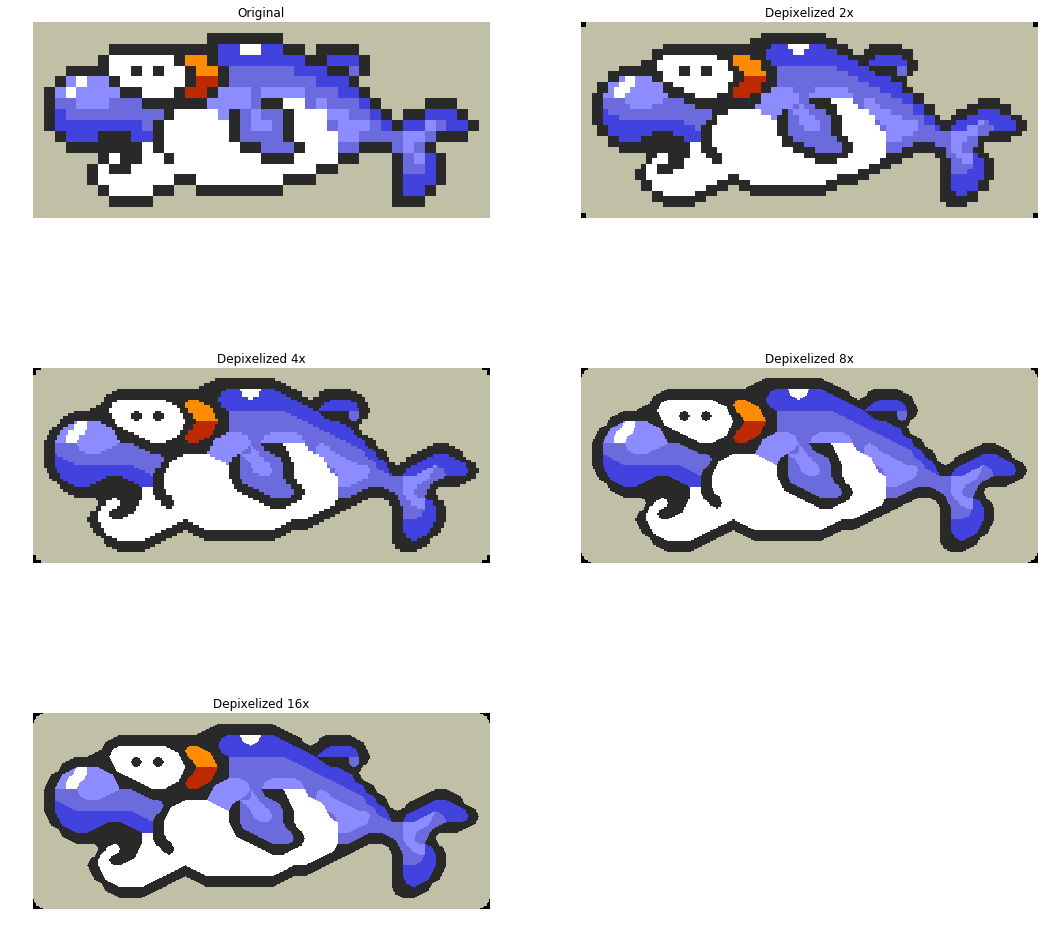

In [0]:
depix = Depixelizer()
dolphin_2x = depix.depixelize('dolphin.png', 0, "2x")
dolphin_4x = depix.depixelize('dolphin.png', 0, "4x")
dolphin_8x = depix.depixelize('dolphin.png', 0, "8x")
dolphin_16x = depix.depixelize('dolphin.png', 0, "16x")

fig = plt.figure(figsize=(18, 18))

fig.add_subplot(3, 2, 1)
plt.grid(False)
plt.title("Original")
plt.axis('off')
plt.imshow(depix.img)

fig.add_subplot(3, 2, 2)
plt.grid(False)
plt.title("Depixelized 2x")
plt.axis('off')
plt.imshow(dolphin_2x)

fig.add_subplot(3, 2, 3)
plt.grid(False)
plt.title("Depixelized 4x")
plt.axis('off')
plt.imshow(dolphin_4x)

fig.add_subplot(3, 2, 4)
plt.grid(False)
plt.title("Depixelized 8x")
plt.axis('off')
plt.imshow(dolphin_8x)

fig.add_subplot(3, 2, 5)
plt.grid(False)
plt.title("Depixelized 16x")
plt.axis('off')
plt.imshow(dolphin_16x)

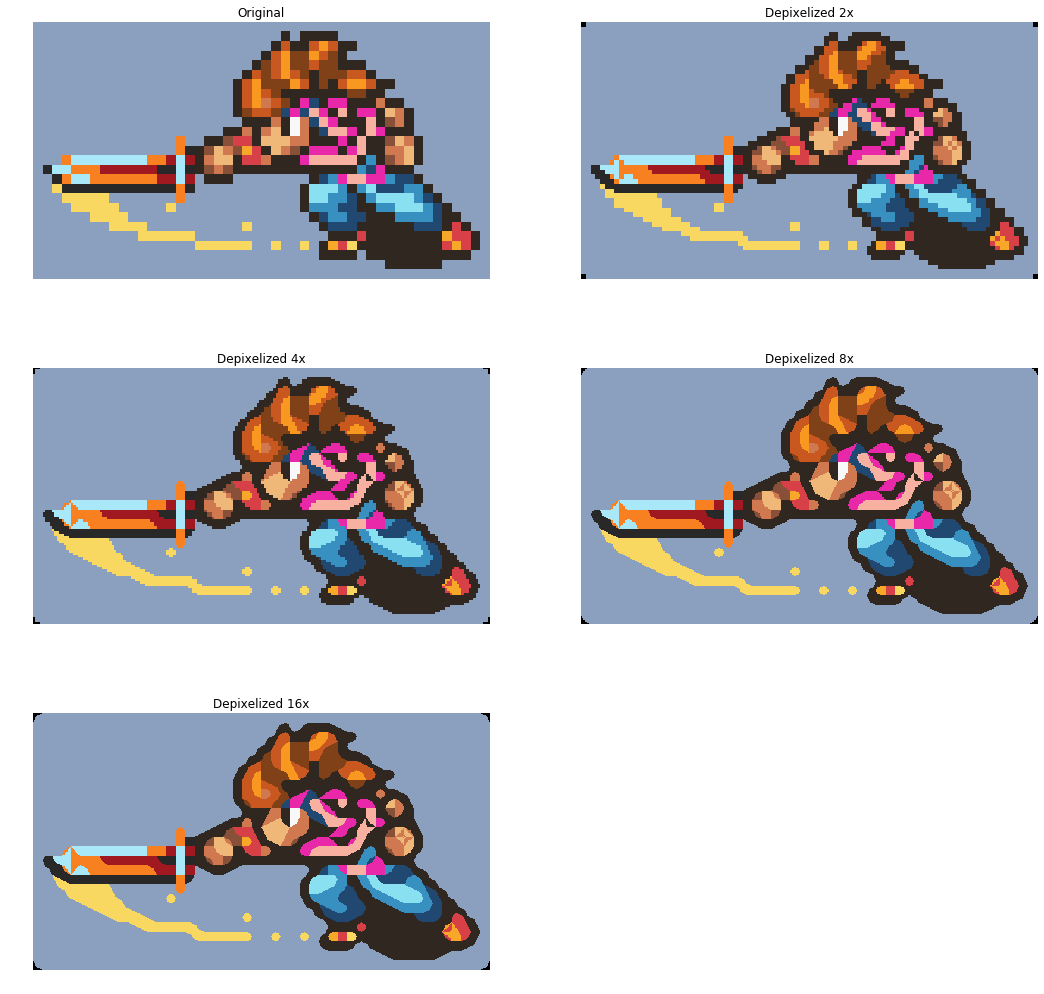

In [0]:
warrior_2x = depix.depixelize('warrior.png', 0, "2x")
warrior_4x = depix.depixelize('warrior.png', 0, "4x")
warrior_8x = depix.depixelize('warrior.png', 0, "8x")
warrior_16x = depix.depixelize('warrior.png', 0, "16x")

fig = plt.figure(figsize=(18, 18))

fig.add_subplot(3, 2, 1)
plt.grid(False)
plt.title("Original")
plt.axis('off')
plt.imshow(depix.img)

fig.add_subplot(3, 2, 2)
plt.grid(False)
plt.title("Depixelized 2x")
plt.axis('off')
plt.imshow(warrior_2x)

fig.add_subplot(3, 2, 3)
plt.grid(False)
plt.title("Depixelized 4x")
plt.axis('off')
plt.imshow(warrior_4x)

fig.add_subplot(3, 2, 4)
plt.grid(False)
plt.title("Depixelized 8x")
plt.axis('off')
plt.imshow(warrior_8x)

fig.add_subplot(3, 2, 5)
plt.grid(False)
plt.title("Depixelized 16x")
plt.axis('off')
plt.imshow(warrior_16x)

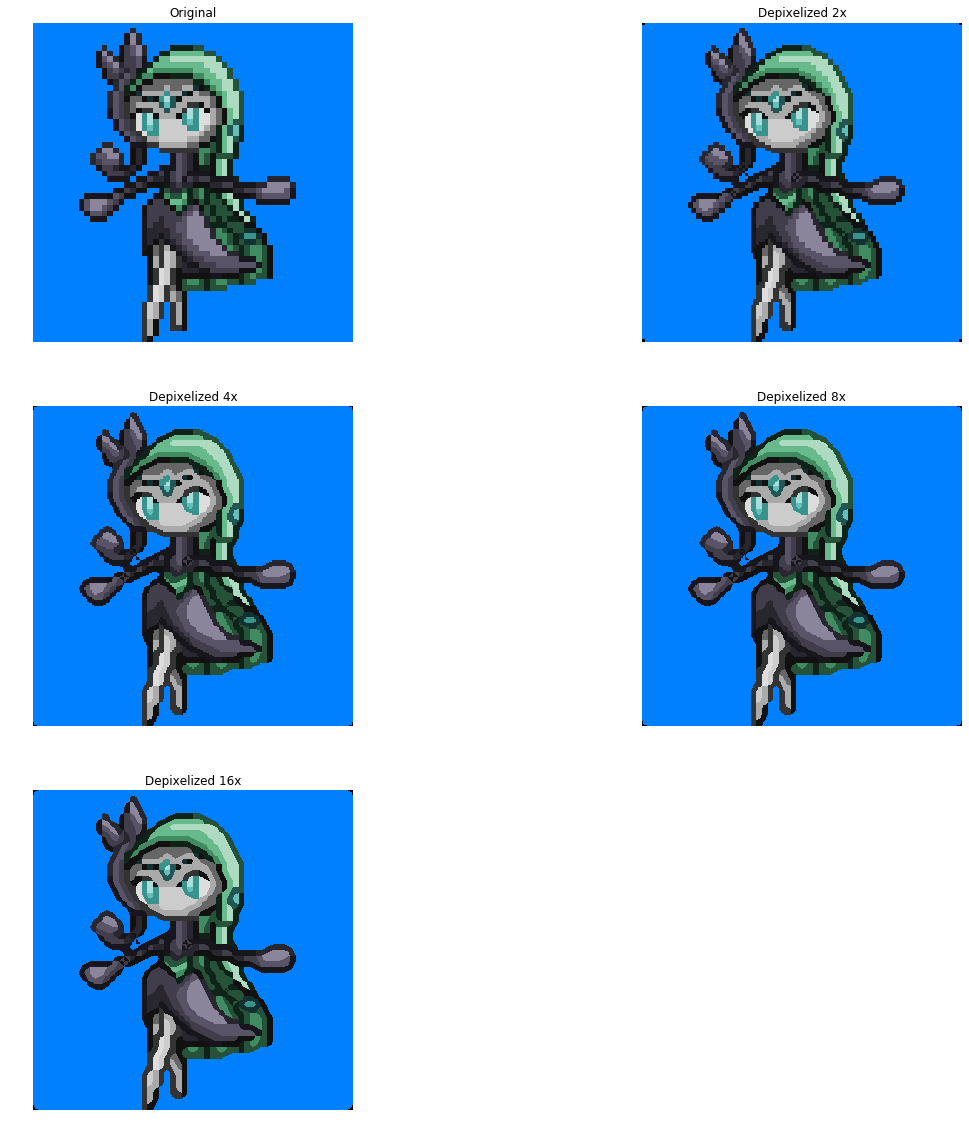

In [0]:
pok1_2x = depix.depixelize('meloetta.png', 0, "2x")
pok1_4x = depix.depixelize('meloetta.png', 0, "4x")
pok1_8x = depix.depixelize('meloetta.png', 0, "8x")
pok1_16x = depix.depixelize('meloetta.png', 0, "16x")

fig = plt.figure(figsize=(20, 20))

fig.add_subplot(3, 2, 1)
plt.grid(False)
plt.title("Original")
plt.axis('off')
plt.imshow(depix.img)

fig.add_subplot(3, 2, 2)
plt.grid(False)
plt.title("Depixelized 2x")
plt.axis('off')
plt.imshow(pok1_2x)

fig.add_subplot(3, 2, 3)
plt.grid(False)
plt.title("Depixelized 4x")
plt.axis('off')
plt.imshow(pok1_4x)

fig.add_subplot(3, 2, 4)
plt.grid(False)
plt.title("Depixelized 8x")
plt.axis('off')
plt.imshow(pok1_8x)

fig.add_subplot(3, 2, 5)
plt.grid(False)
plt.title("Depixelized 16x")
plt.axis('off')
plt.imshow(pok1_16x)

Here we can see a **failed case** in our testing. The upscaled *boo* is deformed severelly compared to the actual pixel-art image, mostly in the mouth and hand regions. The eyes also don't seem right. So, we can conclude that the algorithm performs well for some images, while badly for others.

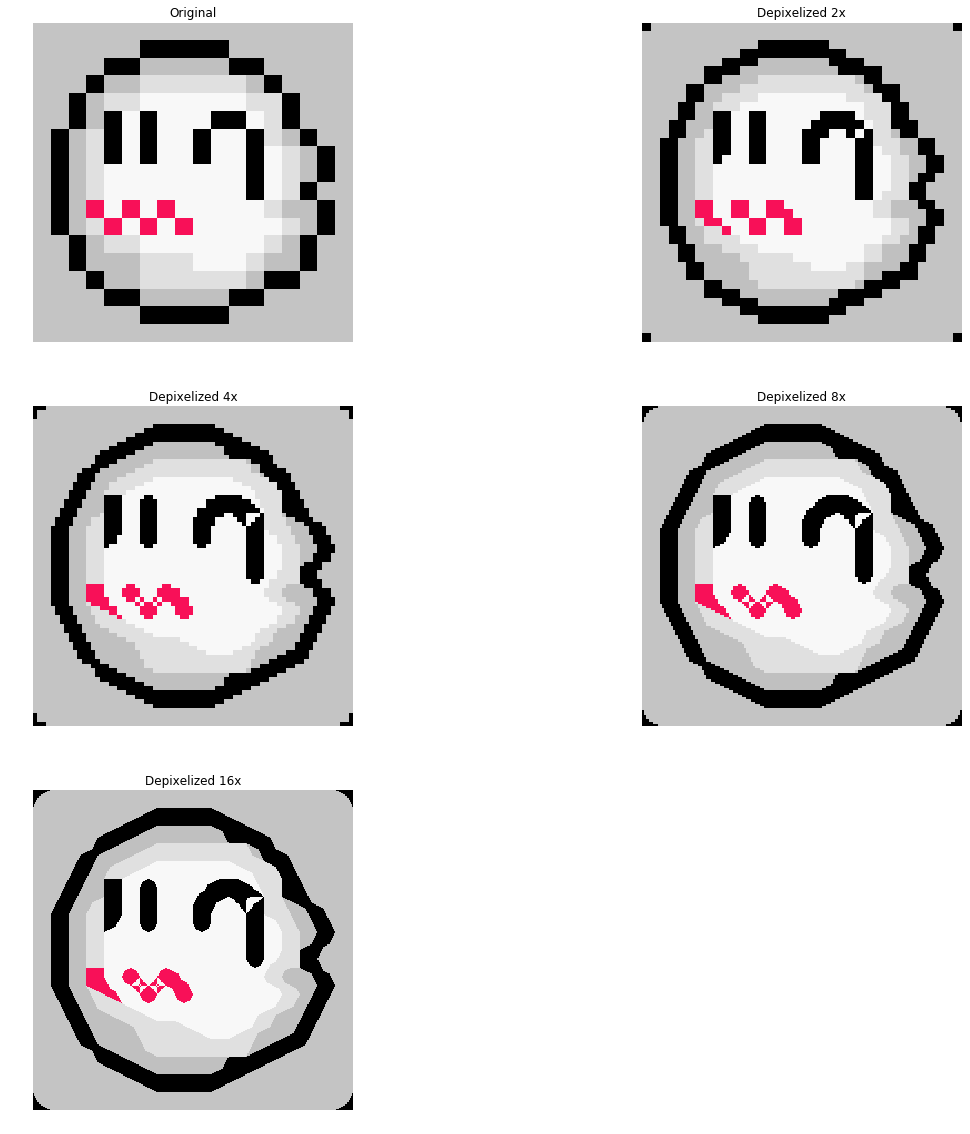

In [0]:
boo_2x = depix.depixelize('boo_depix.png', 0, "2x")
boo_4x = depix.depixelize('boo_depix.png', 0, "4x")
boo_8x = depix.depixelize('boo_depix.png', 0, "8x")
boo_16x = depix.depixelize('boo_depix.png', 0, "16x")

fig = plt.figure(figsize=(20, 20))

fig.add_subplot(3, 2, 1)
plt.grid(False)
plt.title("Original")
plt.axis('off')
plt.imshow(depix.img)

fig.add_subplot(3, 2, 2)
plt.grid(False)
plt.title("Depixelized 2x")
plt.axis('off')
plt.imshow(boo_2x)

fig.add_subplot(3, 2, 3)
plt.grid(False)
plt.title("Depixelized 4x")
plt.axis('off')
plt.imshow(boo_4x)

fig.add_subplot(3, 2, 4)
plt.grid(False)
plt.title("Depixelized 8x")
plt.axis('off')
plt.imshow(boo_8x)

fig.add_subplot(3, 2, 5)
plt.grid(False)
plt.title("Depixelized 16x")
plt.axis('off')
plt.imshow(boo_16x)

## Section 5 - Bonus Content - GIFs and ASCII


This section contains bonus content that we thought would be fun to implement with the algorithms we had. So, if we can transform a pixel-art image to a smooth one and vice-versa, why don't we do it for GIFs? Here we can see an example of the usage of this methods for animations (a pixel-art Sonic running) produced by the use of GIF formats.

While the focus of this project is mainly in pixel-art, why not do the same for ASCII-art? Below we can check what an image looks in ASCII art representation (the Deadpool image is great!). The filename can be passed as parameter to the function *convert_to_ascii* (like the last cell in this colab) and the ASCII art is saved in an image called *results.png*. The factor of the block division is given by the last parameter of the function (**Note**: this is different than the pixelized version, so consider  values such as 1 or 2 to get the best results).

In [0]:
import imageio
import matplotlib.pyplot as plt
import matplotlib.colors as color
import numpy as np
from skimage.transform import resize
from PIL import Image, ImageDraw, ImageFont, ImageSequence

In [0]:
#return all Images in gif as RGB images
def read_gif(filename):
    gif = Image.open(filename)
    r = []
    for frame in ImageSequence.Iterator(gif):
        size = frame.size
        frame = list(frame.convert('RGB').getdata())
        r.append(np.array(np.reshape(frame, (size[1], size[0], 3))))
    return r

In [0]:
# This function checks if two lists are equal given some tolerance
def is_equal(a, b, tolerance=0):
    if np.all(abs(a-b) <= tolerance):
      return True
    else: 
      return False

In [0]:
def scale2x(img, tolerance, factor):
    # Gathering the number of iterations of the algorithm (2x, 4x, 8x, etc)
    n_iterations = 0
    if(factor == "2x"):
      n_iterations = 1
    elif(factor == "4x"):
      n_iterations = 2
    elif(factor == "8x"):
      n_iterations = 3
    elif(factor == "16x"):
      n_iterations = 4
    else:
      print("Please provide either: '2x', '4x','8x' or '16x' as factor values.")
      return None
  
    for i in range(0, n_iterations):
      # Copying the image so that we dont lose the original one
      height, width, depth = img.shape
      # Padding the image border
      img = cv2.copyMakeBorder(img,1,1,1,1,cv2.BORDER_CONSTANT,value=(0, 0, 0)).astype(np.uint8)

      # Declaring the upscaled image that will be returned
      upscaled_img = np.zeros((height*2, width*2, depth)).astype(np.uint8)
      
      # Looping through the image and upscaling
      for i in range(0, height):
        for j in range(0, width):
          # Se B diferente de H e D diferente de F
          if (not is_equal(img[i,j+1], img[i+2,j+1], tolerance)) \
            and (not is_equal(img[i+1,j], img[i+1,j+2], tolerance)):
            # Se D igual a B
            if is_equal(img[i+1,j], img[i,j+1], tolerance):
              # E0 recebe D
              upscaled_img[2*i,2*j] = img[i+1,j]
            else:
              # Se nao, recebe E
              upscaled_img[2*i,2*j] = img[i+1,j+1]
            # Se B igual a F
            if is_equal(img[i,j+1], img[i+1,j+2], tolerance):
              # E1 recebe F
              upscaled_img[2*i,(2*j)+1] = img[i+1,j+2]
            else:
              # Se nao, recebe E
              upscaled_img[2*i,(2*j)+1] = img[i+1,j+1]
            # Se D igual a H
            if is_equal(img[i+1,j], img[i+2,j+1], tolerance):
              # E2 recebe D
              upscaled_img[(2*i)+1,(2*j)] = img[i+1,j]
            else:
              # Se nao, recebe E
              upscaled_img[(2*i)+1,(2*j)] = img[i+1,j+1]
            # Se H igual a F
            if is_equal(img[i+2,j+1], img[i+1,j+2], tolerance):
              # E3 recebe F
              upscaled_img[(2*i)+1,(2*j)+1] = img[i+1,j+2]
            else:
              # Se nao, recebe E
              upscaled_img[(2*i)+1,(2*j)+1] = img[i+1,j+1]
          else:
            upscaled_img[2*i,2*j] = img[i+1,j+1]
            upscaled_img[2*i,(2*j)+1] = img[i+1,j+1]
            upscaled_img[(2*i)+1,(2*j)] = img[i+1,j+1]
            upscaled_img[(2*i)+1,(2*j)+1] = img[i+1,j+1]
        
      # Preparing for the next iteration
      img = upscaled_img
    
    # Returning the upscaled image back to the caller
    return img

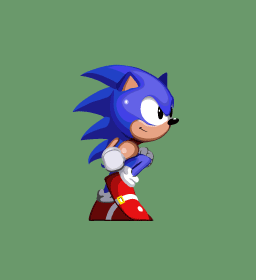

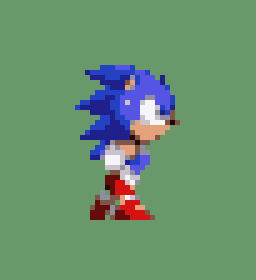

In [0]:
from IPython.display import Image as Img

gif = read_gif("sonic.gif")

r_gif = []
pix2=Pixelizer()

for i in range(len(gif)):
  upscaled = pix2.pixelize_with_image(gif[i], 50, 200, 12, contour=False).astype(np.uint8)
  r_gif.append(upscaled)

kwargs = {'fps': 1000 / Image.open("sonic.gif").info['duration']}
imageio.mimsave('test.gif', r_gif, **kwargs)

display(Img(data=open("sonic.gif", "rb").read(),format='png'),Img(data=open("test.gif", "rb").read(), format='png'))

In [0]:
"""
this func returns a list of string ['', '', ...] each string represents a row in the img
"""
def img_to_ascii(img, dark_background=False, ratio = 2):
    """
    i got this .txt in http://mewbies.com/geek_fun_files/ascii/ascii_art_light_scale_and_gray_scale_chart.htm
    where 
    <-- Denser ----------------------------------------------- Sparser -->
    $@B%8&WM#*oahkbdpqwmZO0QLCJUYXzcvunxrjft/\|()1{}[]?-_+~<>i!lI;:,"^`'.

    so char_map[0] will be the darkest and char_map[-1] the lightest on bright background
    """
    file_char_map = open("ascii_list.txt", "r")
    char_map = file_char_map.read()
    file_char_map.close()

    #if its a color img
    if(len(img.shape) > 2):
        img = np.average(img, axis=2, weights = [0.21, 0.72, 0.07])
        
    #getting the smaller img
    smol_img = resize(img, (img.shape[0] // (2*ratio), img.shape[1] // (1*ratio)), anti_aliasing=True, mode='constant')

    #preparing result list
    result = ['' for i in range(smol_img.shape[0])]
    
    #small img will be in range of [0..255]
    smol_img_max = np.max(smol_img)
    smol_img_min = np.min(smol_img)
    smol_img = (smol_img - smol_img_min)/ (smol_img_max - smol_img_min)
    smol_img = (smol_img * (np.power(2, 8) - 1)).astype(np.uint8)

    #if dark_background == True then tranform small img into its negative
    if(dark_background):
        smol_img = 256 - smol_img

    #size of each div
    size_div = np.ceil(256/len(char_map)).astype(np.uint8)

    test = np.zeros(len(char_map))

    #looping through image to get the characteres
    for i in range(smol_img.shape[0]):
        for j in range(smol_img.shape[1]):
            result[i] += char_map[(smol_img[i][j] // size_div)]
            test[(smol_img[i][j] // size_div)] += 1

    return result

#writes result of img_to_ascii into "result.txt" as default
def write_ascii_img(ascii_img, result_txt="result.txt"):
    result = open(result_txt, "w")

    for row in ascii_img:
        result.write(row)
        result.write("\n")

    result.close()
#writes the result of img_to_ascii in img version
def ascii_txt_to_img(ascii_txt, invert=False, write_img=True, result_img="result.png"):
    result_txt = ''
    for row in ascii_txt:
        result_txt += row
        result_txt += "\n"

    
    #draw the message on the background
    aux = Image.new('L', (1,1), 0)
    draw = ImageDraw.Draw(aux)
    font = ImageFont.truetype('mono.ttf', size=10)
    shape = draw.multiline_textsize(result_txt, font=font)
    
    if invert:
        color = 'rgb(255, 255, 255)' # white color
        image = Image.new('L', shape, 0)
    else:
        color = 'rgb(0, 0, 0)' # black color
        image = Image.new('L', shape, 255)
    # initialise the drawing context with
    # the image object as background
    draw = ImageDraw.Draw(image)

    draw.multiline_text((0, 0), result_txt, fill=color, font=font)
    if write_img:
        image.save(result_img)
    size = image.size
    frame = list(image.convert('RGB').getdata())
    
    return np.array(np.reshape(frame, (size[1], size[0], 3)))

In [0]:
def convert_to_ascii(filename, ratio, dark=True):
  img = imageio.imread(filename)
  ascii_txt_to_img(img_to_ascii(img, dark_background=dark, ratio = ratio), invert=dark)

In [0]:
# Put your filename here and see the ascii result in the file "result.png"!
convert_to_ascii('deadpool.jpg', 1)